In [1]:
using DrWatson
@quickactivate "Attitude Control"

In [2]:
using CBinding

In [3]:
const c"int8_t"  = Int8
const c"uint8_t"  = UInt8

const c"int16_t"  = Int16
const c"uint16_t"  = UInt16

const c"int32_t"  = Int32
const c"uint32_t" = UInt32

const c"int64_t"  = Int64
const c"uint64_t" = UInt64;

In [4]:
LD_PATH = [
    "../build/",
]

INC_PATH = [
    "../lib/libutil/include/",
    "../lib/libadcs/include/",
    "../lib/libadcs/lib/libadcs_client/include",
]

LD_PATH = map(p -> "-L"*p, LD_PATH)
INC_PATH = map(i -> "-I"*i, INC_PATH)
LIB = "shadcs";

In [5]:
## C environment
c`$(INC_PATH) $(LD_PATH) -l$(LIB)`
# Setup includes

# Don't konw why these are needed, but for some reason, they are :S
c"""
#include <gs/util/types.h>
#include <gs/adcs/adcs_types.h>

#include <gs/adcs/param/host/sensor_css.h>
#include <gs/adcs/param/host/sensor_common.h>
#include <gs/adcs/param/host/sensor_fss.h>
#include <gs/adcs/param/host/sensor_extgyro.h>
#include <gs/adcs/param/host/sensor_horizon.h>
#include <gs/adcs/param/host/sensor_extmag.h>
#include <gs/adcs/param/host/sensor_startracker.h>
#include <gs/adcs/param/host/sensor_a3200.h>

#include <gs/adcs/param/host/act_magnetorquer.h>
#include <gs/adcs/param/host/act_rw.h>

#include <gs/adcs/param/host/gnc_common.h>
#include <gs/adcs/param/host/gnc_ads.h>
#include <gs/adcs/param/host/gnc_ctrl_pointing.h>
#include <gs/adcs/param/host/gnc_ctrl_spin.h>
"""

c"""
#include <gs/adcs/adcs_param_types.h>
#include <gs/adcs/adcs_telem_types.h>

#include <gs/adcs/acs/controller/gs_adcs_wheel.h>
""";

In [6]:
gnc = Libc.malloc(c"gs_adcs_config_gnc_t"(
        common=(
            inertia=(1,2,3),
        )
    )
)

periph = Libc.malloc(c"gs_adcs_config_periph_t"())
fss = Libc.malloc(c"gs_adcs_sensor_fss_memory_t"())

conf = Libc.malloc(c"gs_adcs_config_t"(
        gnc=gnc, periph=periph
    )
)

ephem = Libc.malloc(c"gs_adcs_ephem_t"())

state_est = Libc.malloc(c"GS_ADCS_UKF_Data_t"(
        EstimatedState=(
            1.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.01
        )
    )
)

act_data = Libc.malloc(c"gs_adcs_actuatordata_t"())
ctrl = Libc.malloc(c"gs_adcs_ctrl_t"(ref_q=(q4=1.0,)))

# Get handle to function. 
# Could also do c"gs_adcs_wheel_ctrl"(conf, ephem, state_est, act_data, ctr)
_smc = c"gs_adcs_wheel_ctrl"[];

In [7]:
using Plots
using StaticArrays
using LinearAlgebra
using DifferentialEquations, DiffEqCallbacks
using SatelliteToolbox, ReferenceFrameRotations

In [8]:
include("../src/dynamics.jl")
include("../src/demo_controller.jl")

# . due to it begin in the Main.<module> scope and not global scope
using .SpacecraftModel

In [9]:
## Private stuff
function get_q_lvlh(r, v)
    r = r / norm(r)
    v = v / norm(v)

    x =  v           # Velocity vector
    y = -cross(r, v) # negative momentum vector
    z = -r           # Nadir vector

    A_lvlh = DCM([
        x y z
    ])

    q = dcm_to_quat(A_lvlh)
    end

function LVLH_reference(int)
    p = get_parameters(int)
    _, r, v = propagate!(p.orbit, SpacecraftModel.get_time(int))

    q = get_q_lvlh(r, v)

    #Hanlde q sign
    if(p.qᵣ' * q < 0)
        q = -q
    end

    p.qᵣ = q
end

LVLH_reference (generic function with 1 method)

In [10]:
function smc(int)
    p = get_parameters(int)
    q, ω = get_states(int)

    qᵣ = LVLH_reference(int)
    ωᵣ = zeros(3)
    
    #qᵣ = inv(qᵣ)
    
    #q = inv(q)
    q_imag = imag(q)
    state_est.EstimatedState[1] = q_imag[1]
    state_est.EstimatedState[2] = q_imag[2]
    state_est.EstimatedState[3] = q_imag[3]
    state_est.EstimatedState[4] = real(q)
    
    state_est.EstimatedState[5] = ω[1]
    state_est.EstimatedState[6] = ω[2]
    state_est.EstimatedState[7] = ω[3]
    
    qᵣ = inv(qᵣ)
    qᵣ_imag = imag(qᵣ)
    ctrl.ref_q.q1[] = qᵣ_imag[1]
    ctrl.ref_q.q2[] = qᵣ_imag[2]
    ctrl.ref_q.q3[] = qᵣ_imag[3]
    ctrl.ref_q.q4[] = real(qᵣ)
    
    _smc(conf, ephem, state_est, act_data, ctrl)
        
    tmp = SA[ctrl.mw_torque[][1], ctrl.mw_torque[][2], ctrl.mw_torque[][3], ctrl.mw_torque[][4]]
    p.u_rw = tmp

    #qₑ = inv(qᵣ * q)
    #ωₑ = ω - ωᵣ
    #e = [imag(qₑ); ωₑ]

    #u = -p.extra_pars.K * e
    #u_rw₀, u_mag = monetum_man(p.h_rw, p.J, p.L, p.extra_pars)

    #p.u_rw = pinv(p.L) * u + u_rw₀
    #p.h_rw = p.h_rw + p.u_rw * p.Δt
    #p.u_mag = u_mag
end

smc (generic function with 1 method)

In [11]:
# Setup parameters
tle_str = """
AAUSAT3
1 39087U 13009B   21104.06202311  .00000136  00000-0  61744-4 0  9999
2 39087  98.4313 308.7965 0013354 104.8269 255.4393 14.35917261425956
"""
tle = read_tle_from_string(tle_str)[1];

J = diagm([0.07680; 0.0998; 0.0364])
L = pinv([0.5 0.8660 0; 0.5 0 0.8660;  0.5 -0.8660 0; 0.5 0 -0.8660])
orbit = init_orbit_propagator(Val(:J4), tle);

In [12]:
gnc.common.inertia[1] = J[1,1]
gnc.common.inertia[2] = J[2,2]
gnc.common.inertia[3] = J[3,3]

gnc.ctrl.mw_smc[1] =    0.2000
gnc.ctrl.mw_smc[2] =   -0.0001
gnc.ctrl.mw_smc[3] =    0.0010
gnc.ctrl.mw_gain[1] =  -0.0005

-0.0005

In [13]:
for i in 1:length(L)
    periph.act.mw.inv_layout[i] = L[i]
end

In [14]:
pars = Parameters(J=J, L=L, orbit=orbit)

# Random initial conditions
q₀ = randn(4); q₀ = q₀ / norm(q₀);
ω₀ = randn(3); ω₀ = ω₀ / norm(ω₀) * deg2rad(1);
x₀ = [q₀; ω₀]

# Simulation time
t_orb = 24*60*60 / tle.n
sim_n = 0.05
sim_t = sim_n*t_orb

function save_func(x, t, int)
    q = Quaternion(x[1:4])
    p = get_parameters(int)

    (q, p.qᵣ, p.u_rw, p.h_rw, p.u_mag)
end

safe_func_type = Tuple{Quaternion{Float64}, Quaternion{Float64}, SVector{4, Float64}, SVector{4, Float64}, SVector{3, Float64}}

# Setup callback functions
saved_values = SavedValues(Float64, safe_func_type)
callbacks = CallbackSet(
    PeriodicCallback(smc, pars.Δt),
    SavingCallback(save_func, saved_values),
)

# run!
sol = run_simulation(x₀, pars, sim_t, callbacks);

In [15]:
# Perforamnce calculations based on saved values during the simulation
# Extract all the values with map functions (and reduce to colloct some of the in matrices)
q =  map(v -> v[1], saved_values.saveval)
qᵣ = map(v -> v[2], saved_values.saveval)

# mapreduce for takes a really long time for some reason. To it in two steps
u = map(v -> v[3], saved_values.saveval) # Get the u vector
u = reduce(hcat, u)                      # Collect into a matrix
h = map(v -> v[4], saved_values.saveval) # Get the h vector
h = reduce(hcat, h)                      # Collect into a matrix

u_mag = map(v -> v[5], saved_values.saveval)
u_mag = reduce(hcat, u_mag)  

qₑ = map((q, qᵣ) -> qᵣ * q, q, qᵣ);

ang = map(rot -> [rot.a1, rot.a2, rot.a3],
    map(q -> quat_to_angle(q, :XYZ), qₑ)
)
θ = map(a -> rad2deg(a[1]), ang)
ϕ = map(a -> rad2deg(a[2]), ang)
ψ = map(a -> rad2deg(a[3]), ang);

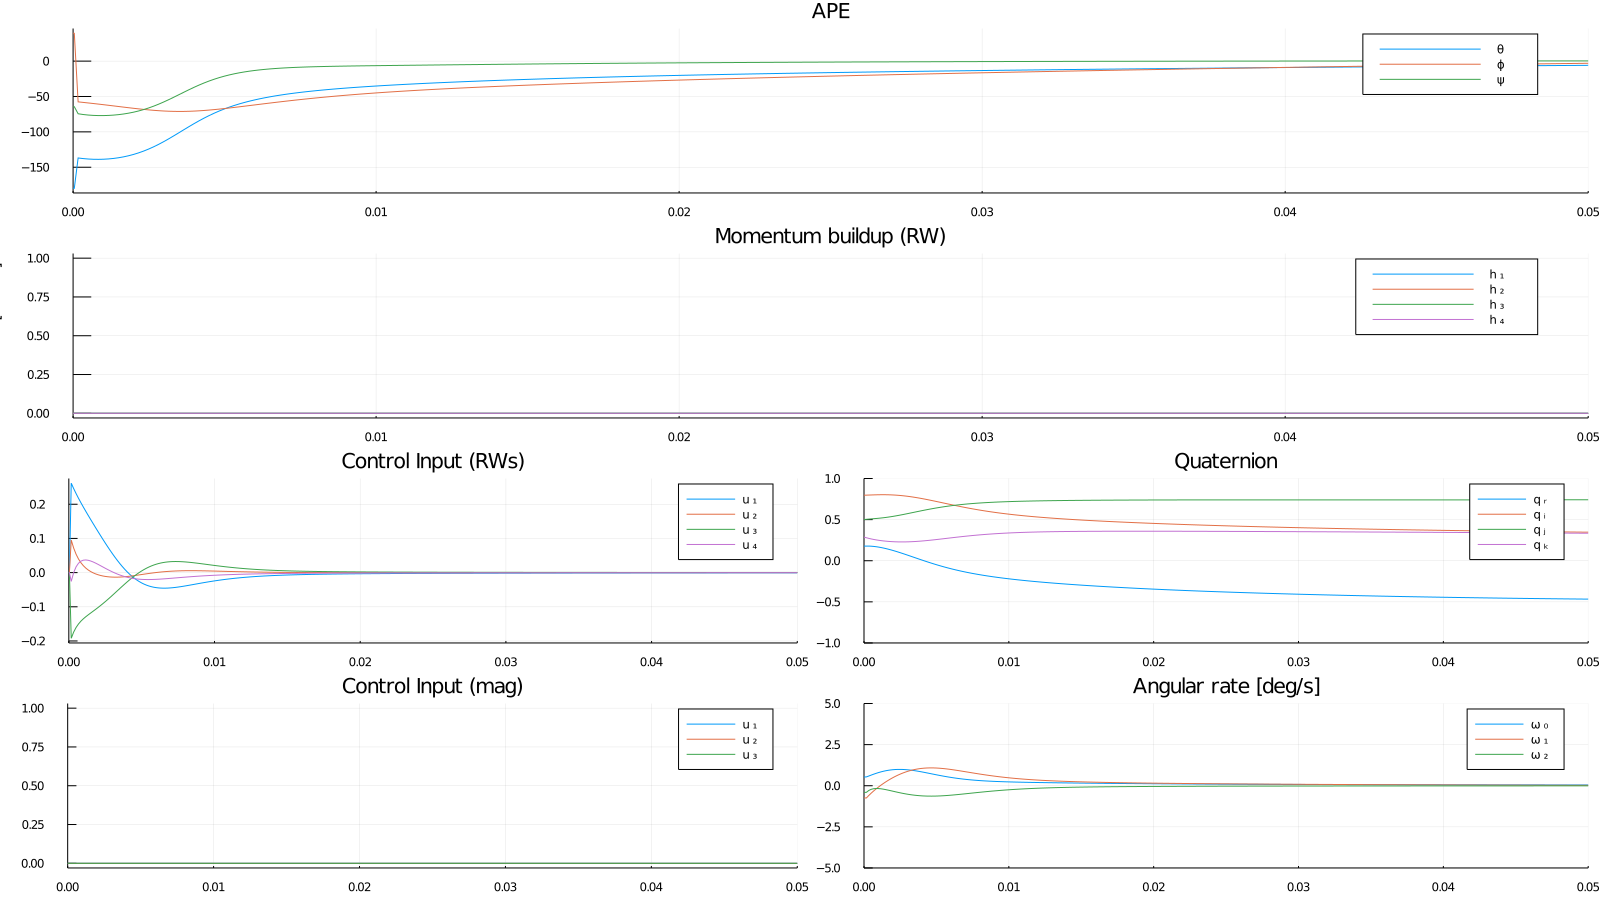

In [16]:
# plots all the stuff
saved_t = saved_values.t / t_orb
ode_t = sol.t / t_orb

ape = plot(saved_t , [θ ϕ ψ],
    title="APE",
    label=["θ" "ϕ" "ψ"],
    ylabel="Angle [deg]",
    xlims=(0, sim_n),
    #ylims=(-10,10),
)

u_rw_plot = plot(saved_t , 1e3*u',
    title="Control Input (RWs)",
    label=["u ₁" "u ₂" "u ₃" "u ₄"],
    ylabel="Torque [mNm]",
    xlims=(0, sim_n),
    ylims=(),
)

u_mag_plot = plot(saved_t , 1e3*u_mag',
    title="Control Input (mag)",
    label=["u ₁" "u ₂" "u ₃"],
    ylabel="Torque [mNm]",
    xlims=(0, sim_n),
    ylims=(),
)

h_plot = plot(saved_t , 1e3*h',
    title="Momentum buildup (RW)",
    label=["h ₁" "h ₂" "h ₃" "h ₄"],
    ylabel="Momentum [mNms]",
    xlims=(0, sim_n),
    ylims=(),
)

q_plot = plot(sol.t / t_orb, sol[1:4, :]', 
    title="Quaternion",
    #ylabel="Value [⋅]",
    xlims=(0, sol.t[end] / t_orb),
    ylims=(-1,1),
    label=["q ᵣ" "q ᵢ" "q ⱼ" "q ₖ"]
)

ω_plot = plot(sol.t / t_orb, rad2deg.(sol[5:7, :]'), 
    title="Angular rate [deg/s]",
    #ylabel="[deg/s]",
    xlims=(0, sol.t[end] / t_orb),
    ylims=(-5,5),
    label=["ω ₀" "ω ₁" "ω ₂"]
)

plot(ape, h_plot, u_rw_plot, q_plot, u_mag_plot, ω_plot,
    size=(1600,900),
    layout=@layout[a; b; c d; e f]
)